In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 5.1 MB/s 


In [ ]:
pip install -U fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 209 kB 69.2 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 112 kB 63.0 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 147 kB 42.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=0798c6571367f1ab1b1deb8b6bfa7b912dcb628b4e111e800c4036755d21791b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import random
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization,Dropout
from tensorflow.keras import models, layers, losses, optimizers, activations, regularizers
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
import joblib
import pickle
from keras.engine.input_spec import InputSpec
initializer = tf.keras.initializers.Zeros()
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tcn import TCN

In [ ]:
flow = np.load('/content/drive/MyDrive/CNN model data/lung_data/flow400.npy')
volume = np.load('/content/drive/MyDrive/CNN model data/lung_data/volume400.npy')
paw = np.load('/content/drive/MyDrive/CNN model data/lung_data/paw400.npy')
capacitances = np.load('/content/drive/MyDrive/CNN model data/lung_data/capacitances400.npy')
resistances = np.load("/content/drive/MyDrive/CNN model data/lung_data/rins400.npy")
#output1 = np.load("/content/drive/MyDrive/CNN model data/output1.npy")
#input1 = np.load("/content/drive/MyDrive/CNN model data/input1.npy")

In [ ]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [ ]:
def normalize_data(data, minimum = None,maximum = None):
    if minimum is None:
        minimum = np.min(np.min(data))
    if maximum is None:
        maximum = np.max(np.max(data))
    data_norm = (data - minimum) / (maximum - minimum)
    return minimum, maximum, data_norm


In [ ]:
flow = flow.T
volume = volume.T
paw = paw.T
resistances = resistances.T
capacitances = capacitances.T

print("transposed")

num_examples = flow.shape[0]
num_samples = flow.shape[1]
print("num_samples are",num_examples)
(min_flow, max_flow, flow) = normalize_data(flow)
(min_volume, max_volume, volume) = normalize_data(volume)
(min_paw, max_paw, paw) = normalize_data(paw)
(min_resistance, max_resistance, resistances) = normalize_data(resistances)
(min_capacitance, max_capacitance, capacitances) = normalize_data(capacitances)

print("normalized data")

input_data = np.zeros((num_examples, num_samples, 3))
input_data[:, :, 0] = flow
input_data[:, :, 1] = volume
input_data[:, :, 2] = paw
output_data = np.concatenate((resistances, capacitances), axis=1)
indices = np.arange(num_examples)

print("input created")

input_train, input_test, output_train, output_test, indices_train, indices_test = \
    train_test_split(input_data, output_data, indices, test_size=0.3, shuffle=False, random_state=11)

input_validation, input_test, output_validation, output_test, indices_validation, indices_test = \
    train_test_split(input_test, output_test, indices_test, test_size=0.5, shuffle=False, random_state=11)

transposed
num_samples are 400
normalized data
input created


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):


    
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return res + x

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    
    x = inputs
    x = layers.Conv1D(filters=2, kernel_size=2)(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.BatchNormalization(name='norm_6')(x)
    x = layers.LeakyReLU(alpha=0.1, name='leaky_relu_6')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    x = layers.Dense(200, activation="relu")(x)
    x = layers.Dropout(0.01)(x)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dropout(0.01)(x)
    outputs = layers.Dense(2)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = input_train.shape[1:]

In [ ]:
def objective(trial):
    reset_random_seeds()
    params = {
              'learning_rate': trial.suggest_uniform('learning_rate', 1e-5, 1e-3),
              'head_size': trial.suggest_int("head_size",128,256),
              'num_heads': trial.suggest_int("num_heads",3,4,5),
              'ff_dim': trial.suggest_int("ff_dim",2,3,4),
              'num_transformer_bock': trial.suggest_int("num_transformer_bock",3,4),
              'decay': trial.suggest_categorical("decay",[1e-3, 1e-5]),
              'dropout_rate': trial.suggest_categorical("dropout_rate", [0.0,0.3]),
              'epochs': trial.suggest_categorical("epochs", [100,150])
              }
    model = build_model(
    input_shape,
    head_size=params['head_size'],
    num_heads=params['num_heads'],
    ff_dim=params['ff_dim'],
    num_transformer_blocks=params['num_transformer_bock'],
    mlp_units=[128],
    mlp_dropout=0.0,
    dropout=0.0,
    )

    model.compile(optimizer=optimizers.Adam(lr=params['learning_rate'], decay=params['decay']), loss=losses.mean_squared_error)

    model.fit(input_train, output_train, epochs=params['epochs'], verbose=1,
            validation_data=(input_validation, output_validation)
            )

    y_pred = model.predict(input_test)
    mse = mean_squared_error(output_test, y_pred)
    mae = mean_absolute_error(output_test,y_pred)
    mape = mean_absolute_percentage_error(output_test,y_pred)

    with open("/content/drive/MyDrive/tcn+transformer/{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return mse

In [ ]:
import optuna
reset_random_seeds()
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21))
study.optimize(objective, n_trials=5)

[I 2022-11-17 17:02:23,804] A new study created in memory with name: no-name-fabb2ab4-e875-4ac9-986c-8428c20b471a
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Epoch 1/100
9/9 [==============================] - 21s 2s/step - loss: 0.6176 - val_loss: 0.1733
Epoch 2/100
9/9 [==============================] - 17s 2s/step - loss: 0.3656 - val_loss: 0.2502
Epoch 3/100
9/9 [==============================] - 17s 2s/step - loss: 0.2908 - val_loss: 0.1074
Epoch 4/100
9/9 [==============================] - 18s 2s/step - loss: 0.2398 - val_loss: 0.1038
Epoch 5/100
9/9 [==============================] - 17s 2s/step - loss: 0.2191 - val_loss: 0.1207
Epoch 6/100
9/9 [==============================] - 17s 2s/step - loss: 0.1834 - val_loss: 0.0897
Epoch 7/100
9/9 [==============================] - 17s 2s/step - loss: 0.1697 - val_loss: 0.1054
Epoch 8/100
9/9 [==============================] - 17s 2s/step - loss: 0.1533 - val_loss: 0.0882
Epoch 9/100
9/9 [==============================] - 18s 2s/step - loss: 0.1504 - val_loss: 0.0956
Epoch 10/100
9/9 [==============================] - 17s 2s/step - loss: 0.1306 - val_loss: 0.0924
Epoch 11/100
9/9 [===========

[I 2022-11-17 17:31:46,556] Trial 0 finished with value: 0.04525207126366099 and parameters: {'learning_rate': 5.8237632001036017e-05, 'head_size': 165, 'num_heads': 3, 'ff_dim': 2, 'num_transformer_bock': 4, 'decay': 1e-05, 'dropout_rate': 0.3, 'epochs': 100}. Best is trial 0 with value: 0.04525207126366099.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [3, 4] and step=5, but the range is not divisible by `step`. It will be replaced by [3, 3].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 20s 2s/step - loss: 1.7994 - val_loss: 0.2640
Epoch 2/150
9/9 [==============================] - 16s 2s/step - loss: 0.2098 - val_loss: 0.1578
Epoch 3/150
9/9 [==============================] - 16s 2s/step - loss: 0.1529 - val_loss: 0.1607
Epoch 4/150
9/9 [==============================] - 16s 2s/step - loss: 0.0969 - val_loss: 0.1357
Epoch 5/150
9/9 [==============================] - 16s 2s/step - loss: 0.0746 - val_loss: 0.1209
Epoch 6/150
9/9 [==============================] - 16s 2s/step - loss: 0.0602 - val_loss: 0.1229
Epoch 7/150
9/9 [==============================] - 15s 2s/step - loss: 0.0501 - val_loss: 0.1189
Epoch 8/150
9/9 [==============================] - 16s 2s/step - loss: 0.0433 - val_loss: 0.1117
Epoch 9/150
9/9 [==============================] - 16s 2s/step - loss: 0.0385 - val_loss: 0.1086
Epoch 10/150
9/9 [==============================] - 16s 2s/step - loss: 0.0338 - val_loss: 0.1092
Epoch 11/150
9/9 [=======================

[I 2022-11-17 17:56:50,784] Trial 1 finished with value: 0.07257944318970125 and parameters: {'learning_rate': 0.0005877553634564128, 'head_size': 136, 'num_heads': 3, 'ff_dim': 2, 'num_transformer_bock': 4, 'decay': 1e-05, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 0 with value: 0.04525207126366099.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [3, 4] and step=5, but the range is not divisible by `step`. It will be replaced by [3, 3].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by 

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 12s 973ms/step - loss: 1.7689 - val_loss: 0.2869
Epoch 2/100
9/9 [==============================] - 8s 917ms/step - loss: 0.2699 - val_loss: 0.1319
Epoch 3/100
9/9 [==============================] - 8s 926ms/step - loss: 0.1318 - val_loss: 0.0839
Epoch 4/100
9/9 [==============================] - 8s 920ms/step - loss: 0.0969 - val_loss: 0.0776
Epoch 5/100
9/9 [==============================] - 8s 919ms/step - loss: 0.0741 - val_loss: 0.0803
Epoch 6/100
9/9 [==============================] - 8s 915ms/step - loss: 0.0632 - val_loss: 0.1009
Epoch 7/100
9/9 [==============================] - 8s 917ms/step - loss: 0.0546 - val_loss: 0.0927
Epoch 8/100
9/9 [==============================] - 8s 920ms/step - loss: 0.0462 - val_loss: 0.1154
Epoch 9/100
9/9 [==============================] - 8s 910ms/step - loss: 0.0432 - val_loss: 0.1115
Epoch 10/100
9/9 [==============================] - 8s 908ms/step - loss: 0.0376 - val_loss: 0.1179
Epoch 11/100
9/9 [==

[I 2022-11-17 18:10:42,349] Trial 2 finished with value: 0.0676102317504762 and parameters: {'learning_rate': 0.0007617095272576973, 'head_size': 177, 'num_heads': 3, 'ff_dim': 2, 'num_transformer_bock': 3, 'decay': 0.001, 'dropout_rate': 0.3, 'epochs': 100}. Best is trial 0 with value: 0.04525207126366099.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [3, 4] and step=5, but the range is not divisible by `step`. It will be replaced by [3, 3].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 12s 940ms/step - loss: 2.3552 - val_loss: 1.5667
Epoch 2/100
9/9 [==============================] - 8s 893ms/step - loss: 0.6618 - val_loss: 0.1820
Epoch 3/100
9/9 [==============================] - 8s 900ms/step - loss: 0.2830 - val_loss: 0.2669
Epoch 4/100
9/9 [==============================] - 8s 892ms/step - loss: 0.2305 - val_loss: 0.1426
Epoch 5/100
9/9 [==============================] - 8s 904ms/step - loss: 0.1759 - val_loss: 0.1584
Epoch 6/100
9/9 [==============================] - 8s 890ms/step - loss: 0.1415 - val_loss: 0.1370
Epoch 7/100
9/9 [==============================] - 8s 893ms/step - loss: 0.1341 - val_loss: 0.1243
Epoch 8/100
9/9 [==============================] - 8s 877ms/step - loss: 0.1255 - val_loss: 0.1252
Epoch 9/100
9/9 [==============================] - 8s 895ms/step - loss: 0.1078 - val_loss: 0.1082
Epoch 10/100
9/9 [==============================] - 8s 893ms/step - loss: 0.1112 - val_loss: 0.1022
Epoch 11/100
9/9 [==

[I 2022-11-17 18:24:17,370] Trial 3 finished with value: 0.0935080403037996 and parameters: {'learning_rate': 0.00017615740756929225, 'head_size': 166, 'num_heads': 3, 'ff_dim': 2, 'num_transformer_bock': 3, 'decay': 1e-05, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 0 with value: 0.04525207126366099.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [3, 4] and step=5, but the range is not divisible by `step`. It will be replaced by [3, 3].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by 

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 15s 1s/step - loss: 2.6471 - val_loss: 0.1473
Epoch 2/150
9/9 [==============================] - 11s 1s/step - loss: 0.1725 - val_loss: 0.1325
Epoch 3/150
9/9 [==============================] - 11s 1s/step - loss: 0.1284 - val_loss: 0.0799
Epoch 4/150
9/9 [==============================] - 11s 1s/step - loss: 0.0901 - val_loss: 0.0745
Epoch 5/150
9/9 [==============================] - 11s 1s/step - loss: 0.0724 - val_loss: 0.0872
Epoch 6/150
9/9 [==============================] - 11s 1s/step - loss: 0.0535 - val_loss: 0.1017
Epoch 7/150
9/9 [==============================] - 11s 1s/step - loss: 0.0466 - val_loss: 0.1198
Epoch 8/150
9/9 [==============================] - 11s 1s/step - loss: 0.0403 - val_loss: 0.2279
Epoch 9/150
9/9 [==============================] - 11s 1s/step - loss: 0.0368 - val_loss: 0.2457
Epoch 10/150
9/9 [==============================] - 11s 1s/step - loss: 0.0330 - val_loss: 0.2308
Epoch 11/150
9/9 [=======================

2/2 [==============================] - 1s 412ms/step


[I 2022-11-17 18:50:59,487] Trial 4 finished with value: 0.0756970240611727 and parameters: {'learning_rate': 0.0008507997862573048, 'head_size': 162, 'num_heads': 3, 'ff_dim': 2, 'num_transformer_bock': 4, 'decay': 0.001, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 0 with value: 0.04525207126366099.


In [ ]:
trial = study.best_trial
print('MSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
with open("/content/drive/MyDrive/tcn+transformer/{}.pickle".format(study.best_trial.number), "rb") as fin:
    best_tcn = pickle.load(fin)
model = best_tcn
y_pred = model.predict(input_test)
mse = mean_squared_error(output_test, y_pred)
print(mse)
print(study.best_trial.number)

MSE: 0.04525207126366099
Best hyperparameters: {'learning_rate': 5.8237632001036017e-05, 'head_size': 165, 'num_heads': 3, 'ff_dim': 2, 'num_transformer_bock': 4, 'decay': 1e-05, 'dropout_rate': 0.3, 'epochs': 100}


2/2 [==============================] - 1s 438ms/step
0.04525207126366099
0


In [ ]:
with open("/content/drive/MyDrive/tcn+transformer/{}.pickle".format(0), "rb") as fin:
    best_transf = pickle.load(fin)
model_transf = best_transf
y_pred = model_transf.predict(input_test)
test_nrmse = np.sqrt(np.sum((output_test - y_pred)**2))/np.sqrt(np.sum((output_test - np.average(output_test))**2))
mse = mean_squared_error(output_test, y_pred)
print("test_nrmse is: ",test_nrmse)
print("test_mse is:", mse)

2/2 [==============================] - 2s 461ms/step
test_nrmse is:  0.8409424951264388
test_mse is: 0.04525207126366099


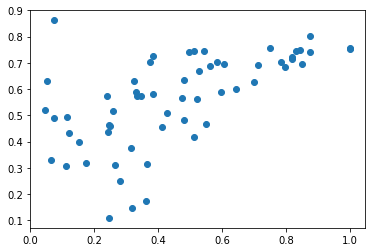

In [ ]:
plt.scatter(output_test[:, 0], y_pred[:, 0])